In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class DielectricBreakdownModel:
    """
    Author: Simone Conradi
    Date: 10/09/23
    
    This class implements a simulation of the dielectric breakdown model described in
    Fractal Dimension of Dielectric Breakdown
    L. Niemeyer, L. Pietronero, ' and H. J. Wiesmann Brown Boveri Research Center, CH-5405 Baden, Switzerland
    
    The model lives on a two-dimensional square lattice.
    In the model, one electrode is depicted as a central point, and the other electrode is represented
    as a distant circle. 
    The growth of the discharge pattern occurs step by step,
    and the electric potential is determined for all lattice points using
    the discrete Laplace equation with specific boundary conditions.
    The growth probability for the discharge pattern depends on the local electric field,
    which is influenced by the existing discharge pattern.
    
    Parameters:
    n (int): The size of the grid
    eta (float): Exponent potential -> probability
    phi0: Potential of the central electrode
    phi1: Potential at the boundary

    """

    def __init__(self, n=100, eta=1., phi0=0.,phi1=1., random_state=None):
        self.n = n
        self.eta = eta
        self.phi0 = phi0
        self.phi1 = phi1
        np.random.seed(random_state) # Set the random seed
        self.lattice = np.zeros((n, n), dtype=np.int8)
        self.potential = np.zeros((n, n), dtype=np.float64)
    
        #bonded particles coordinates and ages
        self.bonded_particles_x = np.zeros(n*n, dtype=np.int16)
        self.bonded_particles_y = np.zeros(n*n, dtype=np.int16)
        self.bonded_particles_age = np.zeros(n*n, dtype=np.int16)
        
        #2d arrays of integer lattice coordinates
        self.x_coords = (np.arange(0,self.n)*np.ones(self.n, dtype=np.int16)[:, np.newaxis]).T
        self.y_coords = (np.arange(0,self.n)*np.ones(self.n, dtype=np.int16)[:, np.newaxis])
        
        #Setting initial conditions
        #central point at potential phi0
        self.n_bonded_particles = 1
        self.bonded_particles_x[0] = n//2
        self.bonded_particles_y[0] = n//2
        self.lattice[n//2, n//2] = 1 
        self.potential[n//2, n//2] = self.phi0
        
        #boundary square at constant potential phi1
        self.potential[0, :] = self.phi1
        self.potential[-1, :] = self.phi1
        self.potential[:, 0] = self.phi1
        self.potential[:, -1] = self.phi1
        
        #Solve discrete laplacian equation for the first time
        self.evolve_potential(10000) #10000 maybe is too much

        #history of the potential
        self.history =[self.potential.copy()]
        
    def evolve_potential(self, n_iter=50):
        """
        Solve dicrete laplacian equation using boundary conditions given by bounded particles
        and fixed boundary potential
        
        Returns: None
        """
        for i in range(n_iter):
            self.potential[1:-1, 1:-1] = 1/4*(self.potential[0:-2, 1:-1] + self.potential[2:, 1:-1] +
                                               self.potential[1:-1, 0:-2] + self.potential[1:-1, 2:])
            self.potential[0, :] = self.phi1
            self.potential[-1, :] = self.phi1
            self.potential[:, 0] = self.phi1
            self.potential[:, -1] = self.phi1
            self.potential[self.bonded_particles_x[0:self.n_bonded_particles], 
                           self.bonded_particles_y[0:self.n_bonded_particles]] = self.phi0

    def step(self):
        """
        Perform a single step of the dielectric breakdown model. Step corresponds a potential evolution
        plus a single bonded particle addition. 
        Use of numpy vectorization.

        Returns: None
        """
        self.evolve_potential(20)
        
        n_bonded_neighbours = (np.roll(self.lattice, (0,1), (0,1)) + np.roll(self.lattice, (0,-1), (0,1)) +
                                 np.roll(self.lattice, (1,0), (0,1)) + np.roll(self.lattice, (-1,0), (0,1)))
        candidates = (n_bonded_neighbours > 0) & (n_bonded_neighbours < 4)
        candidates_coords_x = self.x_coords[candidates]
        candidates_coords_y = self.y_coords[candidates]

        candidates_potential = self.potential[candidates]
        n_candidates = len(candidates_potential)
        candidates_probability = candidates_potential**self.eta/np.sum(candidates_potential**self.eta)
        chosen = np.random.choice(np.arange(n_candidates), p = candidates_probability)

        self.lattice[candidates_coords_x[chosen], candidates_coords_y[chosen]] = 1
        
        self.bonded_particles_x[self.n_bonded_particles] = candidates_coords_x[chosen]
        self.bonded_particles_y[self.n_bonded_particles] = candidates_coords_y[chosen]
        self.bonded_particles_age[:self.n_bonded_particles] += 1
        self.n_bonded_particles += 1
        

    def simulate(self, n_step):
        """
        Simulate the dielectric breakdown  model for n_step steps.
        
        Returns: None
        """
        for _ in range(n_step):
            self.step()
            self.history.append(self.potential.copy())


In [3]:
# Run dielectric breakdown  model simulation
model = DielectricBreakdownModel(n=400, eta=1.4, random_state=0)
model.simulate(6000)

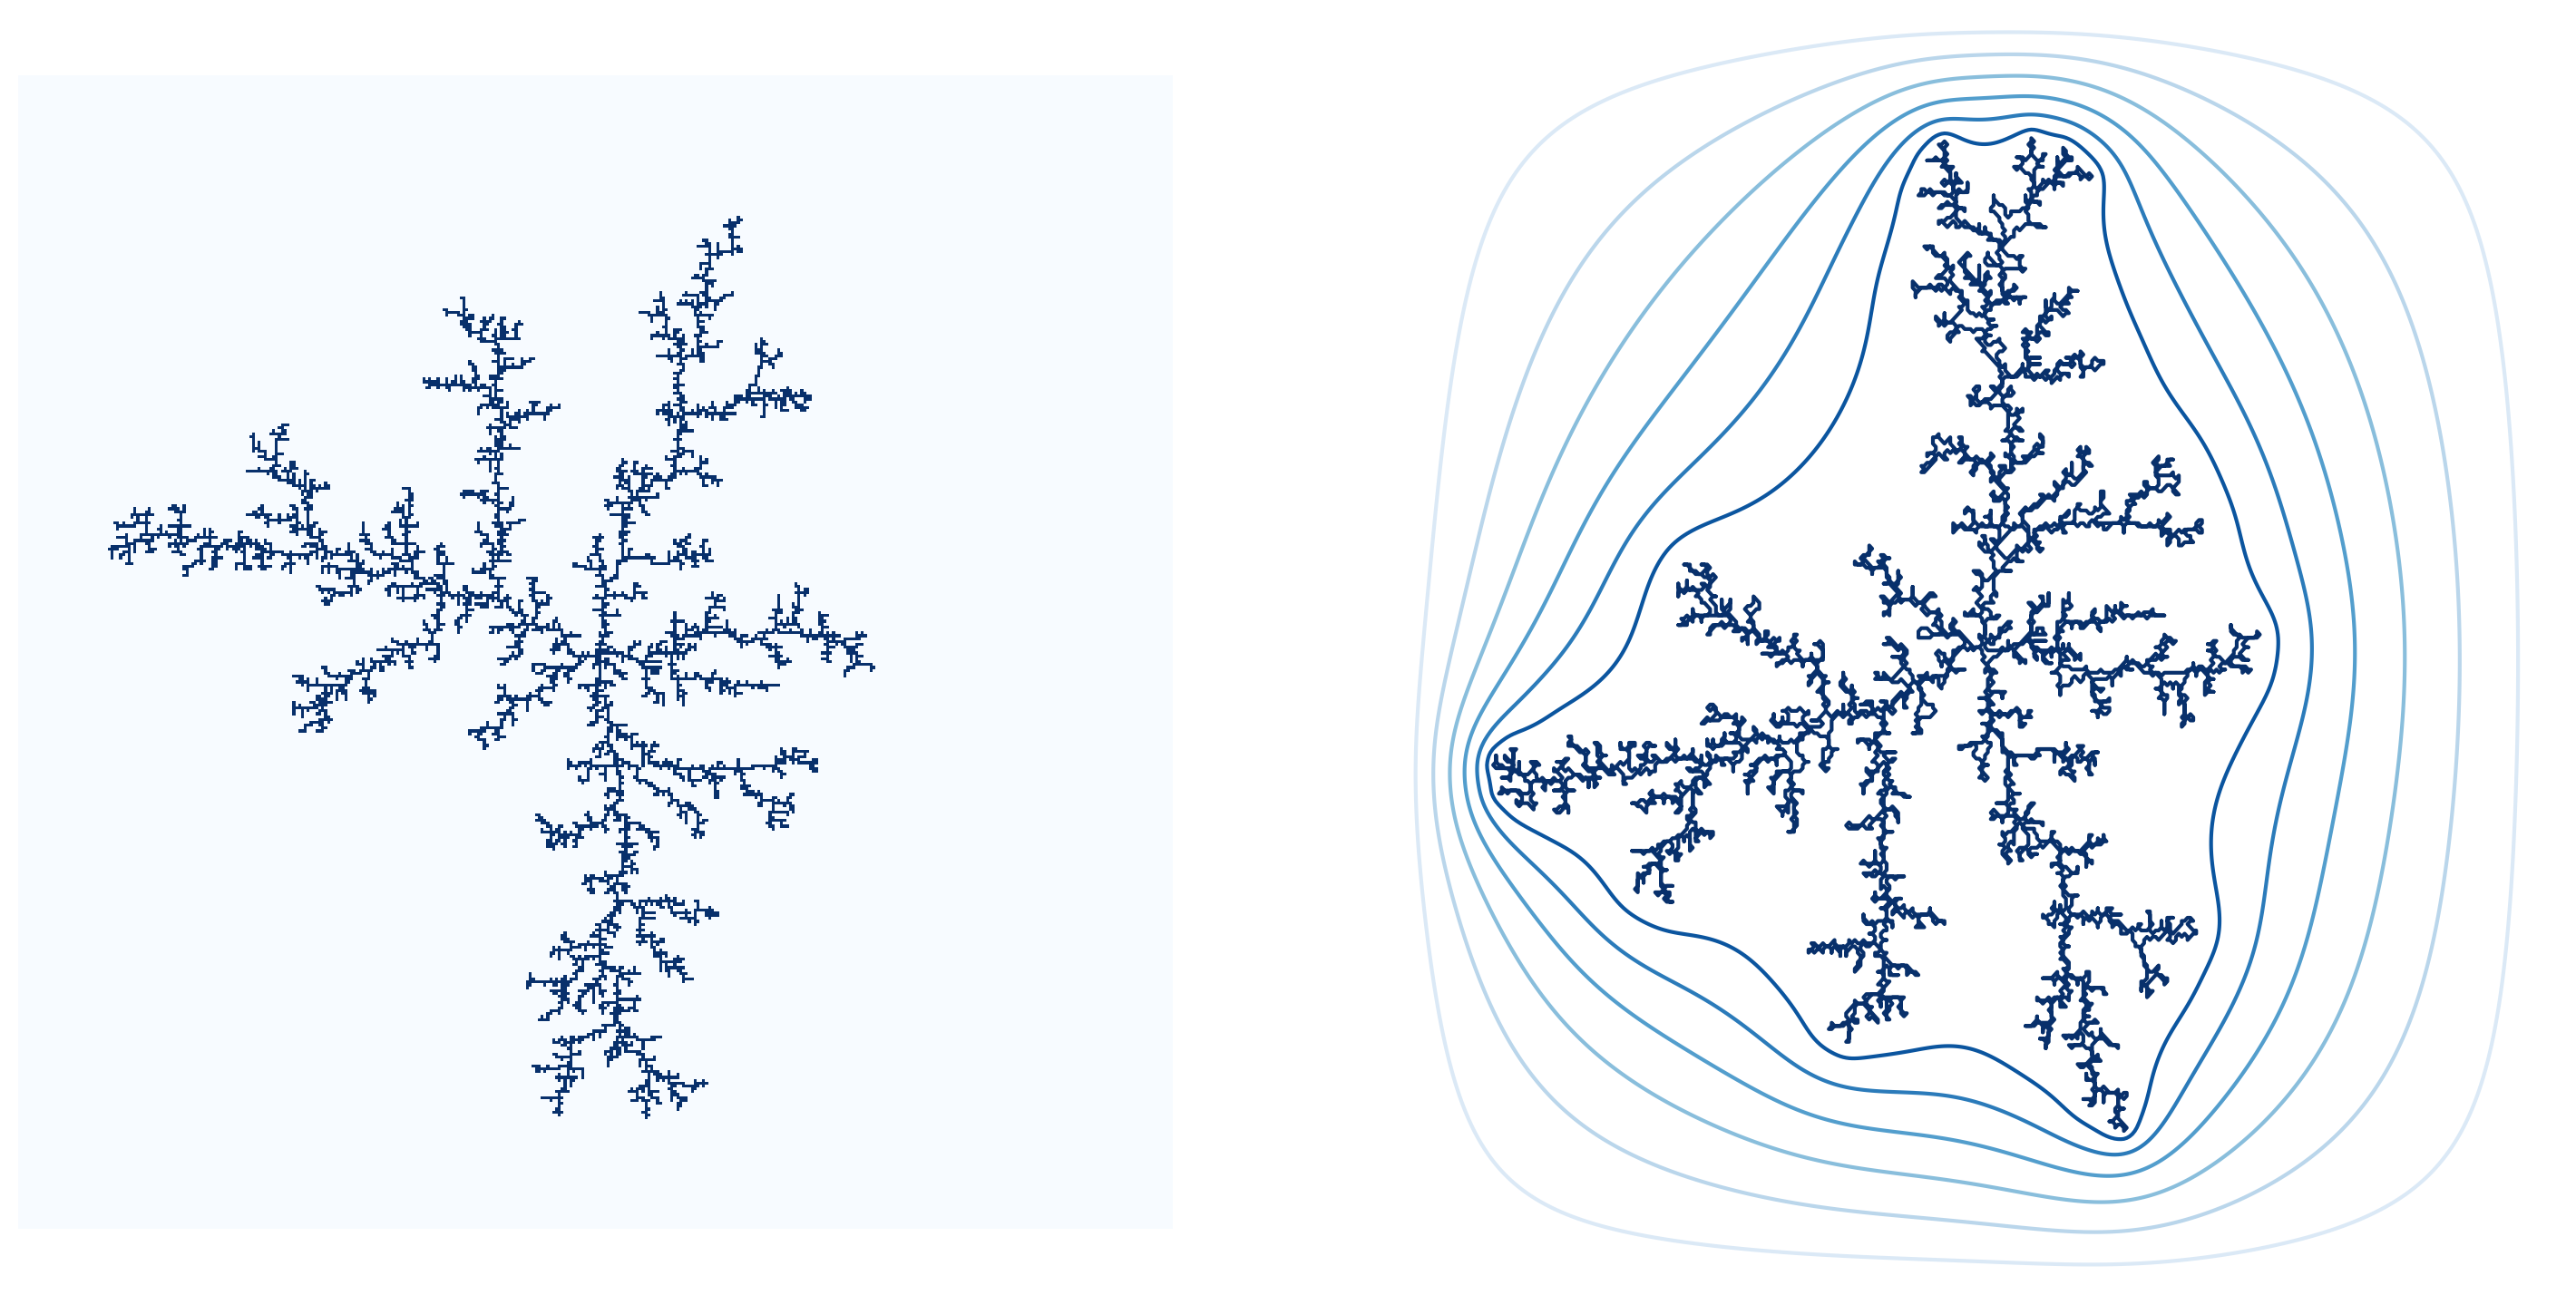

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
axs[0].imshow(model.lattice,cmap="Blues")
axs[0].axis("off")
axs[1].contour(model.potential, cmap="Blues_r")
axs[1].axis("off")
plt.show()

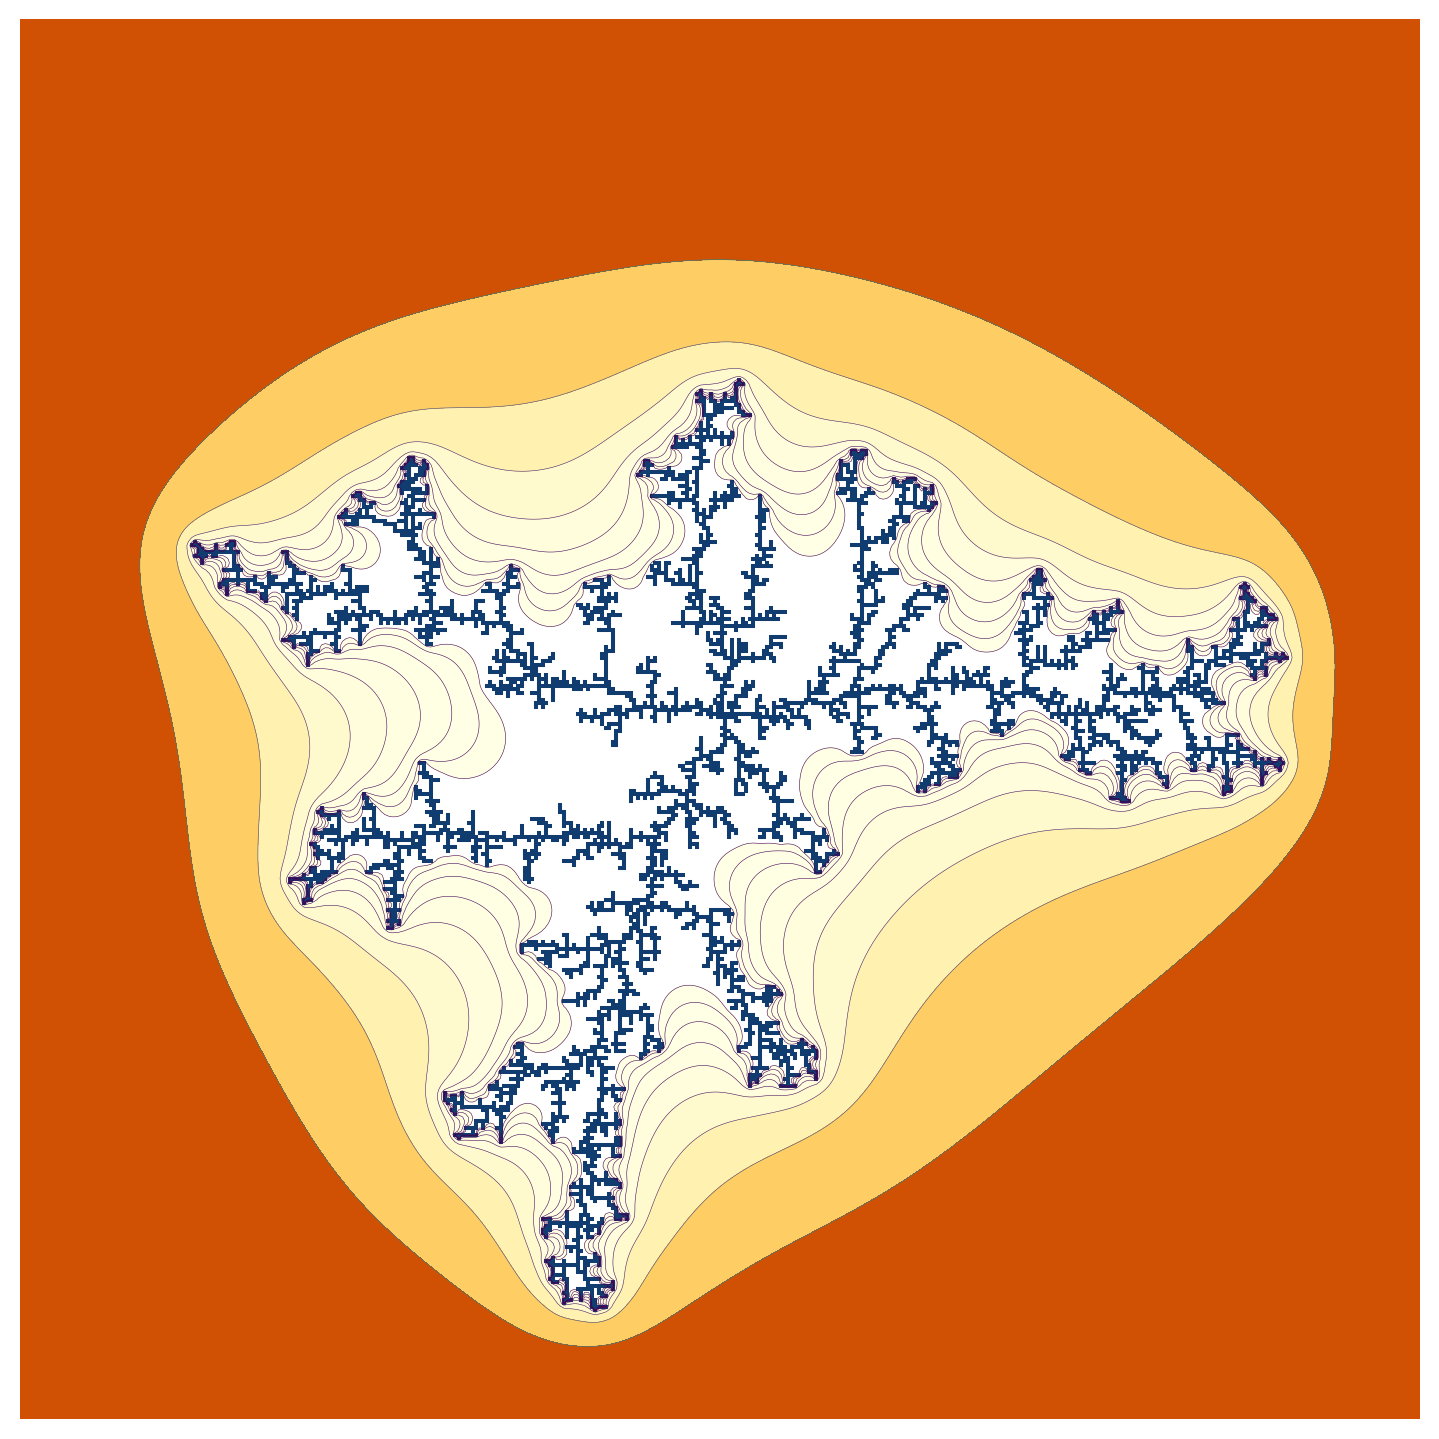

In [9]:
i=6000
fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.contourf(model.history[i].T, cmap="YlOrBr", levels=np.logspace(-3,0,10))
ax.contour(model.history[i].T, levels=np.logspace(-3,0,10), linewidths=0.2)
ax.scatter(model.bonded_particles_x[:i], model.bonded_particles_y[:i], s=2., c="#103c6f", 
                linewidths=0.01, marker="s")
ax.axis("off")
plt.show()

In [ ]:
# This code saves images on files. It is possibile to create an animation using ffmpeg or Quicktime starting from saved images
for i in range(0,6000,10):
    out_path = "./images/frame" + str(i).zfill(5) + ".png"

    plt.figure()
    plt.contourf(model.history[i].T, cmap="YlOrBr", levels=np.logspace(-3,0,10))#, interpolation='spline36', interpolation_stage="rgba")
    plt.contour(model.history[i].T, cmap=sheet_cmap(), levels=np.logspace(-3,0,10), linewidths=0.2)
    plt.scatter(model.bonded_particles_x[:i], model.bonded_particles_y[:i], s=0.7, c="#103c6f", 
                linewidths=0.01, marker="s")
    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close() 